# Pips and imports

In [1]:
# !pip install emoji --upgrade
# !pip install wordcloud
# !python -m spacy download en_core_web_lg
# !pip install gensim
# !pip install sentence_transformers
# !pip install spacy

In [4]:
# Required Libraries
import multiprocessing
import time
from datetime import datetime
cores = multiprocessing.cpu_count()
#Base and Cleaning
import pickle
import pandas as pd
import numpy as np
import emoji
import regex
import re
import string
from collections import Counter
from ast import literal_eval
from operator import itemgetter
#Visualizations
import seaborn as sns
import matplotlib.pyplot as plt
import random
from random import shuffle

#Natural Language Processing (NLP)
from utils.lda_funcs import *
import torch
from tqdm import tqdm
from sentence_transformers import SentenceTransformer,util #  util.cos_sim

tqdm.pandas()
pd.set_option('display.max_columns', 80)


#Warnings
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.simplefilter("ignore", UserWarning)
warnings.simplefilter(action='ignore', category=FutureWarning)
pd.options.mode.chained_assignment = None  # default='warn'

print(f'Num Of Cores:{cores}')
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model_specter = SentenceTransformer('allenai-specter')
model_minilm = SentenceTransformer('all-MiniLM-L6-v2')

def literal(x):
    if x != '':
        return literal_eval(x)
    return x

def align_datasets(pubs, wins, grants):
    # Get the unique ScopusIDs from each dataframe
    pubs_scopus_ids = sorted(pubs['scopus_id'].unique())
    wins_scopus_ids = sorted(wins['ScopusID'].unique())
    grants_scopus_ids = sorted(grants['PI'].unique())

    # Find the minimal intersecting ScopusID strings
    common_scopus_ids = list(set(pubs_scopus_ids) & set(wins_scopus_ids) & set(grants_scopus_ids))

    # Filter out ScopusIDs not in the minimal intersecting list
    pubs = pubs[pubs['scopus_id'].isin(common_scopus_ids)].reset_index(drop=True)
    wins = wins[wins['ScopusID'].isin(common_scopus_ids)].reset_index(drop=True)
    grants = grants[grants['PI'].isin(common_scopus_ids)].reset_index(drop=True)

    return pubs, wins, grants

def find_zero_pubs(x,sampgrants):
    yr = sampgrants[sampgrants['PI'] == x['scopus_id']]['Release_Date'].dt.year.iloc[0]
    columns = [str(year) for year in range(yr, yr - 9, -1)]
    return x[columns].sum()

def filter_res_without_any_rel_papers(sampubs,sampgrants):
    grouped = sampubs.groupby(['scopus_id', 'year']).size().reset_index(name='count')

    pivot_table = pd.pivot_table(grouped, values='count', index='scopus_id', columns='year', fill_value=0).reset_index()
    pivot_table['num_of_rel_papers']  = pivot_table.apply(find_zero_pubs, sampgrants=sampgrants,axis=1)
    sampubs= sampubs[sampubs['scopus_id'].isin(pivot_table[pivot_table['num_of_rel_papers']> 0 ]['scopus_id'].tolist())].reset_index(drop=True)
    sampgrants= sampgrants[sampgrants['PI'].isin(pivot_table[pivot_table['num_of_rel_papers']> 0 ]['scopus_id'].tolist())].reset_index(drop=True)
    return sampubs,sampgrants
def get_sampubs_and_sampgrants(pubs, wins, grants, three_years_after_release=False):

    g_desc = wins[['fiscal_year','ScopusID','full_foa','project_title', 'abstract_text']]\
    .sort_values(by='fiscal_year')\
    .drop_duplicates(subset = ['ScopusID','full_foa'],keep='first')\
    .fillna('')\
    .reset_index(drop=True)

    if three_years_after_release:
        released = grants.groupby(['PI'])['3years_after_release'].min().to_dict() #  LOOK 3 YEARS AFTER WINNING
    else:
        released = grants.groupby(['PI'])['Release_Date'].min().to_dict() 
    
    sampubs = pubs[pubs['scopus_id'].isin(list(released.keys()))].reset_index(drop=True)
    sampubs = sampubs[sampubs['coverDate'] < sampubs['scopus_id'].map(released)].reset_index(drop=True)
    if wins['ScopusID'].unique().shape[0] > sampubs['scopus_id'].unique().shape[0]:
        print(f"{wins['ScopusID'].unique().shape[0] - sampubs['scopus_id'].unique().shape[0]} Researcher dropped due to missing publications retrieval prior to won grant call release date")
        
    sampgrants = grants[grants['PI'].isin(sampubs['scopus_id'].unique())].reset_index(drop=True)

    if three_years_after_release:
        sampgrants = sampgrants[sampgrants['3years_after_release'] <= sampgrants['PI'].map(released)].reset_index(drop=True) # 3 YEARS AFTER WINNING
    else:
        sampgrants = sampgrants[sampgrants['Release_Date'] <= sampgrants['PI'].map(released)].reset_index(drop=True) # BASE 

    sampgrants = sampgrants.drop_duplicates(subset=['PI']).reset_index(drop=True) # sometimes there are anomalies where researchers win two grants at the same date
    ## Add information on the authors submission paper
    sampgrants = sampgrants.merge(g_desc,left_on=['PI','Document_Number'],right_on=['ScopusID','full_foa'],how='inner').drop(columns = ['fiscal_year','ScopusID','full_foa'])
    sampubs = sampubs[sampubs['scopus_id'].isin(sampgrants['PI'].unique())].reset_index(drop=True)

    assert sorted(sampubs['scopus_id'].unique()) == sorted(sampgrants['PI'].unique())
    return sampubs,sampgrants

Num Of Cores:20


# Load data - NIH

### Presenting baseline curated datasets

Grants

In [44]:
grants = pd.read_csv('nih_grantcalls.csv')
wins = pd.read_csv("winning_submission.csv")
wins = wins.drop_duplicates(subset = ['project_title','ScopusID']).reset_index(drop=True)

pubs = pd.read_csv("nih_publications.csv").fillna("")
# BIND between grants and wins
grants = grants.merge(wins[['ScopusID','full_foa']],left_on = 'Document_Number',right_on = 'full_foa')\
.drop(columns = "full_foa").rename(columns = {"ScopusID":"PI"})

c:\Users\gzeevi\AppData\Local\Programs\Python\Python39\lib\site-packages\IPython\core\interactiveshell.py:3444: DtypeWarning: Columns (33,50) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)
c:\Users\gzeevi\AppData\Local\Programs\Python\Python39\lib\site-packages\IPython\core\interactiveshell.py:3444: DtypeWarning: Columns (3) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [45]:
###### used data
# grants= pd.read_csv('nih_grantcalls.csv')
print(f"The general grants dataframe size is {grants.shape[0]:,} \n\
There are {grants['Document_Number'].unique().shape[0]:,} unique grant document numbers\n\
But actually by unique titles, there are only {grants['Title'].unique().shape[0]:,} grant calls\n\
Matched to {grants['PI'].unique().shape[0]:,} different PIs")

The general grants dataframe size is 42,304 
There are 5,785 unique grant document numbers
But actually by unique titles, there are only 3,983 grant calls
Matched to 21,641 different PIs


Winning applications

In [46]:
print(f"The general winning applications dataframe size is {wins['appl_id'].unique().shape[0]:,}\n\
There are {wins['full_foa'].unique().shape[0]:,} unique grant document numbers attached\n\
Matched to {wins['ScopusID'].unique().shape[0]:,} different PIs")

The general winning applications dataframe size is 42,304
There are 5,785 unique grant document numbers attached
Matched to 21,641 different PIs


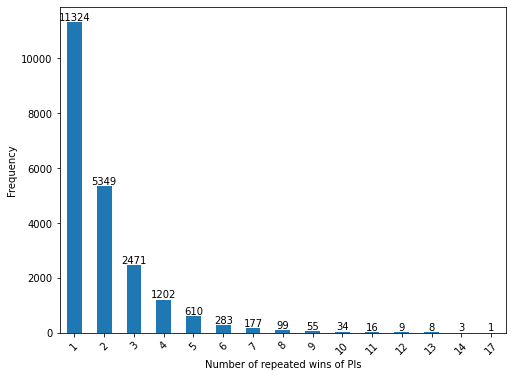

In [47]:
fig, ax = plt.subplots(figsize=(8, 6))
counts = wins['ScopusID'].value_counts()
countvals = pd.Series(counts.values).value_counts()
countvals.plot(kind='bar', ax=ax)

# Adding text labels above each bar
for i, v in enumerate(countvals.values):
    ax.text(i, v, str(v), ha='center', va='bottom')
ax.set_xticklabels(ax.get_xticklabels(), rotation=45)

# Adding axis labels and title
ax.set_xlabel('Number of repeated wins of PIs')
ax.set_ylabel('Frequency')
plt.show()

Publications

In [48]:
print(f"A total of {len(pubs):,} publications have been published by the {pubs['scopus_id'].unique().shape[0]:,} winning Pis up to the retrival point")

A total of 2,740,592 publications have been published by the 21,641 winning Pis up to the retrival point


In [49]:
assert len(pubs['scopus_id'].unique()) == len(wins['ScopusID'].unique())
assert len(pubs['scopus_id'].unique()) == len(grants['PI'].unique())

## Now applying some more filters
- Only grants from 2007 and on
- Drop Grants with general topic
- Only publications from 1999

In [50]:

# Load grants
grants['Expired_Date'] = pd.to_datetime(grants['Expired_Date'])
grants['Release_Date'] = pd.to_datetime(grants['Release_Date'])
### ONLY GRANTS FROM 2007 AND ON
grants = grants[grants['Release_Date'].dt.year >= 2007].reset_index(drop=True)
################################
grants['PI'] = grants['PI'].astype(str)
#There are general grant call winnings. the project called "Research Project Grant" and is a general case
grants = grants.query("Title != 'Research Project Grant' & Title != 'NICHD Research Project Grant' & Title != 'NIH Research Project Grant' & Title != 'INVESTIGATOR-INITIATED INTERACTIVE RESEARCH PROJECT GRANTS' & Title != 'NIBIB Research Project Grant'").reset_index(drop=True)
grants['open_period'] = pd.to_datetime(grants['Expired_Date']).dt.year - pd.to_datetime(grants['Release_Date']).dt.year
grants['3years_after_release'] = grants['Release_Date'] + pd.offsets.DateOffset(years=3)

wins['principal_investigators']=wins['principal_investigators'].apply(literal)
wins['ScopusID'] = wins['ScopusID'].astype(str)
wins = wins[wins['ScopusID'].isin(grants['PI'].unique())].reset_index(drop=True)
# load winners' publications
# pubs = pd.read_csv('/content/drive/MyDrive/Signals_of_expertise/NIH_data/NIH_pubs_filtered_db_final.csv').dropna(subset=['description']).fillna('').reset_index(drop=True)
pubs['coverDate']= pubs['coverDate'].apply(lambda x: x.replace("-00","-01"))
pubs['coverDate'] = pd.to_datetime(pubs['coverDate'])
pubs['scopus_id'] = pubs['scopus_id'].astype(str)
pubs['year'] = pd.to_datetime(pubs['coverDate']).dt.year.astype(str)
pubs['source_id'] =pubs['source_id'].apply(lambda x: str(int(x)) if x != '' else '')
pubs = pubs[pubs['year'] >='1999'].reset_index(drop=True)

print(f"Number of researchers before grants_pubs Anomaly: {grants['PI'].unique().shape}")
############### Dealing with grants before publications ANOMALY ########
# based on grants DB
winnerz = pd.concat([grants['Release_Date'].dt.year,grants['PI']],axis=1).sort_values(by= ['Release_Date','PI']).drop_duplicates(subset = 'PI',keep='first')
pubs_first = pubs[['scopus_id','year']].sort_values(by= ['year','scopus_id']).drop_duplicates(subset = 'scopus_id',keep='first')
earliest_win = pd.Series(index = winnerz['PI'].values,data = winnerz['Release_Date'].values).to_dict()

pubs_first['earliest_win'] = pubs_first['scopus_id'].map(earliest_win)
anomlies_win_before_published = pubs_first[pubs_first['year'].astype(float) > pubs_first['earliest_win']]['scopus_id'].tolist()
pubs = pubs[~pubs['scopus_id'].isin(anomlies_win_before_published)].reset_index(drop=True)
wins = wins[~wins['ScopusID'].isin(anomlies_win_before_published)].reset_index(drop=True)
grants = grants[~grants['PI'].isin(anomlies_win_before_published)].reset_index(drop=True)
print(f"Number of researchers after grants_pubs Anomaly: {grants['PI'].unique().shape}")
#######################################################################


pubs = pubs[pubs['scopus_id'].isin(grants['PI'].unique())].reset_index(drop=True)
pubs = pubs.drop_duplicates(subset=['eid', 'scopus_id']).reset_index(drop=True) # Drop duplicated papers for associated with the same researcher
grants = grants[grants['PI'].isin(pubs['scopus_id'].unique().tolist())].reset_index(drop=True)
wins = wins[wins['ScopusID'].isin(grants['PI'].unique())].reset_index(drop=True)
wins = wins[wins['full_foa'].isin(grants['Document_Number'].unique())].reset_index(drop=True)

pubs, wins, grants = align_datasets(pubs, wins, grants)
pubs_c, wins_c, grants_c = pubs.copy(), wins.copy(), grants.copy()
assert len(pubs['scopus_id'].unique()) == len(wins['ScopusID'].unique())
assert len(pubs['scopus_id'].unique()) == len(grants['PI'].unique())

Number of researchers before grants_pubs Anomaly: (14373,)
Number of researchers after grants_pubs Anomaly: (13791,)


## Measure from released date of grant call

**Examine single winners only, not teams:**

In [51]:
wins = wins[wins['principal_investigators'].apply(len) == 1].reset_index(drop=True)
grants = wins[['ScopusID','full_foa']].drop_duplicates().rename(columns = {"ScopusID":"PI","full_foa":"Document_Number"})\
.merge(grants,on = ['Document_Number','PI'],how='left').reset_index(drop=True)

pubs, wins, grants = align_datasets(pubs, wins, grants)

In [52]:
print(f"There Are {wins['ScopusID'].unique().shape[0]} winners with total of {wins.appl_id.unique().shape[0]} grants proposal approvals")
print(f"Out of {wins['ScopusID'].unique().shape[0]} winners, {(wins['ScopusID'].value_counts() > 1).sum()} researchers won more than one time")
print(f"In general there are {wins['full_foa'].unique().shape[0]} grant calls which yielded {wins.appl_id.unique().shape[0]} grants fundings")

There Are 10885 winners with total of 16207 grants proposal approvals
Out of 10885 winners, 3513 researchers won more than one time
In general there are 2994 grant calls which yielded 16207 grants fundings


There are missing publications prior to won grant call release date for some of the researchers.<br>
We filter them out as well.

In [59]:
released = grants.groupby(['PI'])['Release_Date'].min().to_dict() # Base
# released = grants.groupby(['PI'])['3years_after_release'].min().to_dict() # 3 YEARS AFTER WINNING

sampubs = pubs[pubs['scopus_id'].isin(list(released.keys()))].reset_index(drop=True)
sampubs = sampubs[sampubs['coverDate'] < sampubs['scopus_id'].map(released)].reset_index(drop=True)

sampgrants = grants[grants['PI'].isin(sampubs['scopus_id'].unique())].reset_index(drop=True)

sampgrants = sampgrants[sampgrants['Release_Date'] <= sampgrants['PI'].map(released)].reset_index(drop=True) # BASE
# sampgrants = sampgrants[sampgrants['3years_after_release'] <= sampgrants['PI'].map(released)].reset_index(drop=True) # 3 YEARS AFTER WINNING

sampgrants = sampgrants.drop_duplicates(subset=['PI']).reset_index(drop=True) # sometimes there are anomalies where researchers win two grants at the same date
## Add information on the authors submission paper
# sampgrants = sampgrants.merge(g_desc,left_on=['PI','Document_Number'],right_on=['ScopusID','full_foa'],how='inner').drop(columns = ['fiscal_year','ScopusID','full_foa'])
sampubs = sampubs[sampubs['scopus_id'].isin(sampgrants['PI'].unique())].reset_index(drop=True)

assert sorted(sampubs['scopus_id'].unique()) == sorted(sampgrants['PI'].unique())
sampubs['scopus_id'].unique().shape[0],sampgrants['PI'].unique().shape[0]

sampubs,sampgrants = filter_res_without_any_rel_papers(sampubs,sampgrants)
pubs, wins, grants = align_datasets(sampubs, wins, grants)

# Finally get relevant data
sampubs,sampgrants = get_sampubs_and_sampgrants(pubs, wins, grants, three_years_after_release=False)
sampubs_3years,sampgrants_3years = get_sampubs_and_sampgrants(pubs, wins, grants, three_years_after_release=True)

In [60]:
print(f"There Are {wins['ScopusID'].unique().shape[0]} winners with total of {wins.appl_id.unique().shape[0]} grants proposal approvals")
print(f"Out of {wins['ScopusID'].unique().shape[0]} winners, {(wins['ScopusID'].value_counts() > 1).sum()} researchers won more than one time")
print(f"In general there are {wins['full_foa'].unique().shape[0]} grant calls which yielded {wins.appl_id.unique().shape[0]} grants fundings")

There Are 10810 winners with total of 16084 grants proposal approvals
Out of 10810 winners, 3487 researchers won more than one time
In general there are 2990 grant calls which yielded 16084 grants fundings


---

In [18]:
def create_res_sim_info(sampgrants,sampubs,name= "NIH_SPECTER_released"):
  df_sep_year= pd.DataFrame(index= sampgrants.PI.tolist(),columns = ["Released\nyear","1","2","3","4","5","6","7","8"])[["Released\nyear","1","2","3","4","5","6","7","8"]]
  for pi in tqdm(sampgrants.PI.tolist()):
    sep_year = [[0]]*9
    val = sampgrants[sampgrants['PI'] == pi]
    if "haifa" in name.lower():
      yr = val['GM Submission date'].dt.year.iloc[0]
    else:
      yr = val['Release_Date'].dt.year.iloc[0]
    grant_embed = val['embedded'].item()
    res_pubs = sampubs[sampubs['scopus_id'] == pi].sort_values(by='coverDate',ascending=False).reset_index(drop=True)
    res_pubs['years'] = res_pubs['coverDate'].dt.year
    for i in range(yr,yr-9,-1):
      #sep year case
      tmp = res_pubs[res_pubs['years']==i]
      if len(tmp) < 1:
        continue
      else:
        if "tfidf" in name.lower() or "lda" in name.lower():
          tmp['cos_sim']= tmp['embedded'].apply(lambda x: sparse_cos_sim(x,grant_embed).item())
          sep_year[yr-i] = tmp['cos_sim'].tolist()
        else:
          tmp['cos_sim']= tmp['embedded'].apply(lambda x: util.cos_sim(x,grant_embed).item())
          sep_year[yr-i] = tmp['cos_sim'].tolist()
    df_sep_year.loc[pi] = sep_year
  df_sep_year.to_csv(f'outputs/{name}_per_pub_per_year.csv')

In [19]:
def create_res_sim_info_3years_more(sampgrants,sampubs,name= "NIH_SPECTER_released"):
  df_sep_year= pd.DataFrame(index= sampgrants.PI.tolist(),columns = ["-3","-2","-1","Released\nyear","1","2","3","4","5","6","7","8"])[["-3","-2","-1","Released\nyear","1","2","3","4","5","6","7","8"]]
  for pi in tqdm(sampgrants.PI.tolist()):
    sep_year = [[0]]*12
    val = sampgrants[sampgrants['PI'] == pi]
    if "haifa" in name.lower():
      yr = val['GM Submission date'].dt.year.iloc[0]
    else:
      yr = val['3years_after_release'].dt.year.iloc[0]
    grant_embed = val['embedded'].item()
    res_pubs = sampubs[sampubs['scopus_id'] == pi].sort_values(by='coverDate',ascending=False).reset_index(drop=True)
    res_pubs['years'] = res_pubs['coverDate'].dt.year
    for i in range(yr,yr-12,-1):
      #sep year case
      tmp = res_pubs[res_pubs['years']==i]
      if len(tmp) < 1:
        continue
      else:
        if "tfidf" in name.lower() or "lda" in name.lower():
          tmp['cos_sim']= tmp['embedded'].apply(lambda x: sparse_cos_sim(x,grant_embed).item())
          sep_year[yr-i] = tmp['cos_sim'].tolist()
        else:
          tmp['cos_sim']= tmp['embedded'].apply(lambda x: util.cos_sim(x,grant_embed).item())
          sep_year[yr-i] = tmp['cos_sim'].tolist()
    df_sep_year.loc[pi] = sep_year
  df_sep_year.to_csv(f'outputs/{name}_3yearsmore.csv')

# LDA

In [20]:
# A check to see there arent duplicated grant's document id with different titles
doc_dup = sampgrants['Document_Number'].duplicated()
titl_dup= sampgrants['Title'].duplicated()
assert len(sampgrants[doc_dup & ~titl_dup])<1

In [ ]:
# Base
sampubs_corp = sampubs.drop_duplicates(subset='eid').reset_index(drop=True)
sampgrants_corp = sampgrants.copy()
print(len(sampubs_corp),len(sampgrants_corp)) 

sampubs_corp['lemm_corpus'] = (sampubs_corp['title']+" "+sampubs_corp['description']+" "+sampubs_corp['authkeywords']).progress_apply(preprocess_removestops_lemmatize)
sampubs_corp.drop(columns=['title','description','authkeywords']).to_csv('outputs/nih_sampubs_corp.csv',index=False)
# LOOKING ON GRANT CALLS
sampgrants_corp['lemm_corpus'] =(sampgrants_corp['Title']+" "+sampgrants_corp['descrip']).progress_apply(preprocess_removestops_lemmatize)
sampgrants_corp.drop(columns=['Title','descrip','project_title','abstract_text']).to_csv('outputs/nih_sampgrants_corp.csv',index=False)
# LOOKING ON GRANT PROPOSALS
sampgrants_corp['lemm_corpus'] =(sampgrants_corp['project_title']+" "+sampgrants_corp['abstract_text']).progress_apply(preprocess_removestops_lemmatize)
sampgrants_corp.drop(columns=['Title','descrip','project_title','abstract_text']).to_csv('outputs/nihproj_sampgrants_corp.csv',index=False)

In [ ]:
## 3 years after winning ##
sampubs_corp = sampubs_3years.drop_duplicates(subset='eid').reset_index(drop=True)
sampgrants_corp = sampgrants_3years.copy()
print(len(sampubs_corp),len(sampgrants_corp)) 

sampubs_corp['lemm_corpus'] = (sampubs_corp['title']+" "+sampubs_corp['description']+" "+sampubs_corp['authkeywords']).progress_apply(preprocess_removestops_lemmatize)
sampubs_corp.drop(columns=['title','description','authkeywords']).to_csv('outputs/nih_sampubs_corp_3years.csv',index=False)
#REGULAR
sampgrants_corp['lemm_corpus'] =(sampgrants_corp['Title']+" "+sampgrants_corp['descrip']).progress_apply(preprocess_removestops_lemmatize)
sampgrants_corp.drop(columns=['Title','descrip','project_title','abstract_text']).to_csv('outputs/nih_sampgrants_corp_3years.csv',index=False)
# LOOKING ON GRANTS PROPOSALS
sampgrants_corp['lemm_corpus'] =(sampgrants_corp['project_title']+" "+sampgrants_corp['abstract_text']).progress_apply(preprocess_removestops_lemmatize)
sampgrants_corp.drop(columns=['Title','descrip','project_title','abstract_text']).to_csv('outputs/nihproj_sampgrants_corp_3years.csv',index=False)

## Optimize topics

In [ ]:
sampubs_corp = pd.read_csv('outputs/nih_sampubs_corp.csv').dropna(subset = ['lemm_corpus'])[['eid','lemm_corpus']].reset_index(drop=True)
sampgrants_corp= pd.read_csv('outputs/nih_sampgrants_corp.csv').dropna(subset = ['lemm_corpus'])[['Document_Number','lemm_corpus']].reset_index(drop=True)
comp_corp =  pd.concat([sampubs_corp,sampgrants_corp]).reset_index(drop=True)
id2word = Dictionary(comp_corp['lemm_corpus'].apply(lambda x: x.split()))
# Filtering Extremes
id2word.filter_extremes(no_below=2, no_above=.99)
# Creating a corpus object 
corpus = [id2word.doc2bow(d) for d in comp_corp['lemm_corpus'].apply(lambda x: x.split())]
# Perform Number of topics optimization based on coherence score
bestmodel = compute_coherence_values(dictionary=id2word,
                                                      corpus=corpus,
                                                      texts=comp_corp['lemm_corpus'].apply(lambda x: x.split()),
                                                      cores = cores,
                                                      start=10, limit=80, step=10)
print(f'For the merged corpus, the optimized number of topics {bestmodel.num_topics}')

### Create sparse vector of lda and create cosine relevance data

#### Based on grant calls

In [ ]:
sampubs_corp = pd.read_csv('outputs/nih_sampubs_corp.csv').dropna(subset = ['lemm_corpus'])[['eid','lemm_corpus']].reset_index(drop=True)
sampgrants_corp= pd.read_csv('outputs/nih_sampgrants_corp.csv').dropna(subset = ['lemm_corpus'])[['PI','Document_Number','lemm_corpus']].reset_index(drop=True)

sampubs,sampgrants = get_sampubs_and_sampgrants(pubs, wins, grants, three_years_after_release=False)

## Assigning corpus for lda
comp_corp =  pd.concat([sampubs_corp,sampgrants_corp]).reset_index(drop=True)
id2word = Dictionary(comp_corp['lemm_corpus'].apply(lambda x: x.split()))
# Filtering Extremes
id2word.filter_extremes(no_below=2, no_above=.99)
corpus = [id2word.doc2bow(d) for d in comp_corp['lemm_corpus'].apply(lambda x: x.split())]

model = LdaMulticore(corpus=corpus,
                            num_topics=40,#### NUM OF TOPICS - 40 was optimal
                            id2word=id2word,
                            workers=cores-1,
                            passes=20,
                            random_state=12,
                            decay=0.5,
                          chunksize=2000,)
# Assign sparse vectors
vectors = [model.get_document_topics(doc) for doc in corpus]
sparse_vecs = []
for vec in vectors:
  w = np.zeros(model.num_topics)
  for val in vec:
    w[val[0]] = val[1]
  sparse_vecs.append([w])
comp_corp['embedded'] = sparse_vecs
sampubs_corp_new = comp_corp.iloc[0:len(sampubs_corp['lemm_corpus']),:].drop(columns = ['PI','Document_Number'],axis=1).reset_index(drop=True)
sampgrants_corp_new =comp_corp.iloc[len(sampubs_corp['lemm_corpus'])::,:].drop(columns = ['eid'],axis=1).reset_index(drop=True)

sampubs = sampubs.merge(sampubs_corp_new[['eid','embedded']],on = 'eid').reset_index(drop=True)

sampgrants_corp_new['PI'] = sampgrants_corp_new['PI'].astype(int).astype(str)
sampgrants = sampgrants.merge(sampgrants_corp_new[['PI','Document_Number','embedded']],on = ['PI','Document_Number']).reset_index(drop=True)
create_res_sim_info(sampgrants,sampubs,name= "NIH_LDA_released")


#### Based on grant proposals

In [ ]:
sampubs_corp = pd.read_csv('outputs/nih_sampubs_corp.csv').dropna(subset = ['lemm_corpus'])[['eid','lemm_corpus']].reset_index(drop=True)
sampgrants_corp= pd.read_csv('outputs/nihproj_sampgrants_corp.csv').dropna(subset = ['lemm_corpus'])[['PI','Document_Number','lemm_corpus']].reset_index(drop=True)

sampubs,sampgrants = get_sampubs_and_sampgrants(pubs, wins, grants, three_years_after_release=False)

## Assigning corpus for lda
comp_corp =  pd.concat([sampubs_corp,sampgrants_corp]).reset_index(drop=True)
id2word = Dictionary(comp_corp['lemm_corpus'].apply(lambda x: x.split()))
# Filtering Extremes
id2word.filter_extremes(no_below=2, no_above=.99)
corpus = [id2word.doc2bow(d) for d in comp_corp['lemm_corpus'].apply(lambda x: x.split())]

model = LdaMulticore(corpus=corpus,
                            num_topics=40,#### NUM OF TOPICS -  40 was optimal
                            id2word=id2word,
                            workers=cores-1,
                            passes=20,
                            random_state=12,
                            decay=0.5,
                          chunksize=2000,)
# Assign sparse vectors
vectors = [model.get_document_topics(doc) for doc in corpus]
sparse_vecs = []
for vec in vectors:
  w = np.zeros(model.num_topics)
  for val in vec:
    w[val[0]] = val[1]
  sparse_vecs.append([w])
comp_corp['embedded'] = sparse_vecs
sampubs_corp_new = comp_corp.iloc[0:len(sampubs_corp['lemm_corpus']),:].drop(columns = ['PI','Document_Number'],axis=1).reset_index(drop=True)
sampgrants_corp_new =comp_corp.iloc[len(sampubs_corp['lemm_corpus'])::,:].drop(columns = ['eid'],axis=1).reset_index(drop=True)

sampubs = sampubs.merge(sampubs_corp_new[['eid','embedded']],on = 'eid').reset_index(drop=True)

sampgrants_corp_new['PI'] = sampgrants_corp_new['PI'].astype(int).astype(str)
sampgrants = sampgrants.merge(sampgrants_corp_new[['PI','Document_Number','embedded']],on = ['PI','Document_Number']).reset_index(drop=True)
create_res_sim_info(sampgrants,sampubs,name= "NIHproj_LDA_released")

#### Larger window of 3 years after release year

In [ ]:
sampubs_corp = pd.read_csv('outputs/nih_sampubs_corp_3years.csv').dropna(subset = ['lemm_corpus'])[['eid','lemm_corpus']].reset_index(drop=True)
sampgrants_corp= pd.read_csv('outputs/nih_sampgrants_corp_3years.csv').dropna(subset = ['lemm_corpus'])[['PI','Document_Number','lemm_corpus']].reset_index(drop=True)

sampubs_3years,sampgrants_3years = get_sampubs_and_sampgrants(pubs, wins, grants, three_years_after_release=True)
## Assigning corpus for lda
comp_corp =  pd.concat([sampubs_corp,sampgrants_corp]).reset_index(drop=True)
id2word = Dictionary(comp_corp['lemm_corpus'].apply(lambda x: x.split()))
# Filtering Extremes
id2word.filter_extremes(no_below=2, no_above=.99)
corpus = [id2word.doc2bow(d) for d in comp_corp['lemm_corpus'].apply(lambda x: x.split())]

model = LdaMulticore(corpus=corpus,
                            num_topics=40,#### NUM OF TOPICS -  40 was optimal
                            id2word=id2word,
                            workers=cores-1,
                            passes=20,
                            random_state=12,
                            decay=0.5,
                          chunksize=2000,)
# Assign sparse vectors
vectors = [model.get_document_topics(doc) for doc in corpus]
sparse_vecs = []
for vec in vectors:
  w = np.zeros(model.num_topics)
  for val in vec:
    w[val[0]] = val[1]
  sparse_vecs.append([w])
comp_corp['embedded'] = sparse_vecs
sampubs_corp_new = comp_corp.iloc[0:len(sampubs_corp['lemm_corpus']),:].drop(columns = ['PI','Document_Number'],axis=1).reset_index(drop=True)
sampgrants_corp_new =comp_corp.iloc[len(sampubs_corp['lemm_corpus'])::,:].drop(columns = ['eid'],axis=1).reset_index(drop=True)

sampubs_3years = sampubs_3years.merge(sampubs_corp_new[['eid','embedded']],on = 'eid').reset_index(drop=True)

sampgrants_corp_new['PI'] = sampgrants_corp_new['PI'].astype(int).astype(str)
sampgrants_3years = sampgrants_3years.merge(sampgrants_corp_new[['PI','Document_Number','embedded']],on = ['PI','Document_Number']).reset_index(drop=True)
create_res_sim_info_3years_more(sampgrants_3years,sampubs_3years,name= "NIH_LDA_released")


## Calculate similarity

### SBERT

In [ ]:
# Sbert encoding
sampubs,sampgrants = get_sampubs_and_sampgrants(pubs, wins, grants, three_years_after_release=False)

sampubs['unified'] = sampubs.apply(lambda x: x['title']  + ' '+ x['description'] + ' '+ x['authkeywords'],axis=1)
sampubs['embedded'] = sampubs['unified'].progress_apply(lambda x: model_minilm.encode(x, convert_to_tensor=True,device= device))
sampgrants['unified'] = sampgrants.apply(lambda x: x['Title']  + ' '+ x['descrip'],axis=1)
sampgrants['embedded'] = sampgrants['unified'].progress_apply(lambda x: model_minilm.encode(x, convert_to_tensor=True,device= device))
create_res_sim_info(sampgrants,sampubs,name= "NIH_SBERT_released")

sampgrants['unified'] = sampgrants.apply(lambda x: x['project_title']  + ' '+ x['abstract_text'],axis=1)
sampgrants['embedded'] = sampgrants['unified'].progress_apply(lambda x: model_minilm.encode(x, convert_to_tensor=True,device= device))
create_res_sim_info(sampgrants,sampubs,name= "NIHproj_SBERT_released")

Larger window of 3 years after release year¶

In [ ]:
# Sbert encoding
sampubs_3years,sampgrants_3years = get_sampubs_and_sampgrants(pubs, wins, grants, three_years_after_release=True)

sampubs_3years['unified'] = sampubs_3years.apply(lambda x: x['title']  + ' '+ x['description'] + ' '+ x['authkeywords'],axis=1)
sampubs_3years['embedded'] = sampubs_3years['unified'].progress_apply(lambda x: model_minilm.encode(x, convert_to_tensor=True,device= device))
sampgrants_3years['unified'] = sampgrants_3years.apply(lambda x: x['Title']  + ' '+ x['descrip'],axis=1)
sampgrants_3years['embedded'] = sampgrants_3years['unified'].progress_apply(lambda x: model_minilm.encode(x, convert_to_tensor=True,device= device))
create_res_sim_info_3years_more(sampgrants_3years,sampubs_3years,name= "NIH_SBERT_released")

### SPECTER


In [ ]:
# Specter encoding
sampubs3['unified'] = sampubs3.apply(lambda x: x['title']  + '[SEP]'+ x['description'] + ' '+ x['authkeywords'],axis=1)
sampubs3['embedded'] = sampubs3['unified'].progress_apply(lambda x: model_specter.encode(x, convert_to_tensor=True,device= device))
sampgrants3['unified'] = sampgrants3.apply(lambda x: x['Title']  + '[SEP]'+ x['descrip'],axis=1)
sampgrants3['embedded'] = sampgrants3['unified'].progress_apply(lambda x: model_specter.encode(x, convert_to_tensor=True,device= device))
create_res_sim_info(sampgrants3,sampubs3,name= "NIH_SPECTER_released")

sampgrants3['unified'] = sampgrants3.apply(lambda x: x['project_title']  + ' '+ x['abstract_text'],axis=1)
sampgrants3['embedded'] = sampgrants3['unified'].progress_apply(lambda x: model_specter.encode(x, convert_to_tensor=True,device= device))
create_res_sim_info(sampgrants3,sampubs3,name= "NIHproj_SPECTER_released")

Larger window of 3 years after release year¶

In [ ]:
sampubs3['unified'] = sampubs3.apply(lambda x: x['title']  + '[SEP]'+ x['description'] + ' '+ x['authkeywords'],axis=1)
sampubs3['embedded'] = sampubs3['unified'].progress_apply(lambda x: model_specter.encode(x, convert_to_tensor=True,device= device))
sampgrants3['unified'] = sampgrants3.apply(lambda x: x['Title']  + '[SEP]'+ x['descrip'],axis=1)
sampgrants3['embedded'] = sampgrants3['unified'].progress_apply(lambda x: model_specter.encode(x, convert_to_tensor=True,device= device))
create_res_sim_info_3years_more(sampgrants3,sampubs3,name= "NIH_SPECTER_released")